In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
#from visualization14 import ANN
#%matplotlib widget

In [2]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
from collections import Counter
# Visualization
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import copy

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.core.decorators import auto_move_data
from torchvision.transforms import ToTensor
from torchvision.models import vgg16,mnasnet0_5
from torch import nn
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.metrics.functional import accuracy
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

In [4]:
BATCH_SIZE = 64
NUM_EPOCHS = 80
LEARNING_RATE = 0.005
NUM_WORKERS = 4

In [5]:
class PyTorchLeNet5(torch.nn.Module):

    def __init__(self, num_classes, grayscale=True):
        super().__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 6, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(6, 16, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),
            torch.nn.Tanh(),
            torch.nn.Linear(120, 84),
            torch.nn.Tanh(),
            torch.nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.classifier(x)
        return x,logits

In [6]:
import pytorch_lightning as pl
import torchmetrics


# LightningModule that receives a PyTorch model as input
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        # The inherited PyTorch module
        self.model = model

        # Save settings and hyperparameters to the log directory
        # but skip the model parameters
        self.save_hyperparameters()#(ignore=['model'])

        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
    # Defining the forward method is only necessary 
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)
        
    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        _,logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        
        # To account for Dropout behavior during evaluation
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc,
                 on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)#Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [7]:
import os

from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader


class DataModule(pl.LightningDataModule):
    def __init__(self,train_data,valid_data):
        super().__init__()
        self.train_data=train_data
        self.valid_data=valid_data
        #self.data_path = data_path
        
    def prepare_data(self):
        #datasets.MNIST(root=self.data_path,
        #               download=True)
        self.resize_transform = transforms.Compose(
            [transforms.Resize((32, 32)),
             transforms.ToTensor()])
        
        return

    def setup(self, stage=None):
        # Note transforms.ToTensor() scales input images
        # to 0-1 range
        
        self.train, self.valid = self.train_data,self.valid_data

    def train_dataloader(self):
        print(len(self.train))
        train_loader = DataLoader(dataset=self.train, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=True,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS)
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(dataset=self.valid, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=False,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)
        return valid_loader

In [8]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


pytorch_model = PyTorchLeNet5(
    num_classes=10, grayscale=True)

lightning_model = LightningModel(
    model=pytorch_model, learning_rate=LEARNING_RATE)

callbacks = [ModelCheckpoint(
    save_top_k=1, mode='max', monitor="valid_acc")]  # save top 1 model 
logger = CSVLogger(save_dir="logs/", name="my-model")

In [9]:
transform = transforms.Compose(
            [transforms.Resize((32, 32)),
             transforms.ToTensor()])

# Select Randomly 200 points to start AL training 

In [10]:
FashionMNIST('/.', train=True, download=True)
FashionMNIST('/.', train=False, download=True)#data_dir
#transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),transforms.ToTensor()])
dataset_full = FashionMNIST('/.',train=True,transform=transform)
dataset_train = FashionMNIST('/.',train=True,transform=transform)

#print(type(dataset_full),len(dataset_full)) 
dataset_train, dataset_val,remaining = random_split(dataset_full, [200,10000,49800])
#print(len(dataset_train),type(dataset_train))
dataset_train_original=copy.deepcopy(dataset_train)

In [11]:
torch.manual_seed(1) 
data_module = DataModule(dataset_train, dataset_val)

In [12]:
import time


trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    progress_bar_refresh_rate=50,  # recommended for notebooks
    #accelerator="auto",  # Uses GPUs or TPUs if available
    #devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    log_every_n_steps=100)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)

runtime = (time.time() - start_time)/60
print(f"Training took {runtime:.2f} min in total.")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

200


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training took 17.06 min in total.


In [13]:
def prepare_test_embeddings(dataset_train):

    test_loader = DataLoader(dataset=dataset_train, 
                                     batch_size=BATCH_SIZE, 
                                     drop_last=False,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)
    test_dataloader = test_loader

    all_true_labels = []
    all_predicted_labels = []
    #test_imgs = torch.zeros((0, 1, 32, 32), dtype=torch.float32)
    test_embeddings = torch.zeros((0, 400), dtype=torch.float32)
    for batch in test_dataloader:
        features, labels = batch

        with torch.no_grad():  # since we don't need to backprop
            embeddings, logits = lightning_model(features)
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        predicted_labels = torch.argmax(logits, dim=1)
        all_predicted_labels.append(predicted_labels)
        all_true_labels.append(labels)
        #test_imgs = torch.cat((test_imgs, features.detach().cpu()), 0)
    #test_imgs = np.array(test_imgs)

    test_embeddings = np.array(test_embeddings)
    all_predicted_labels = torch.cat(all_predicted_labels)
    all_true_labels = torch.cat(all_true_labels)
    all_predicted_labels=np.array(all_predicted_labels)
    all_true_labels=np.array(all_true_labels)

    test_acc = np.sum(all_predicted_labels == all_true_labels)
    final_test_acc = test_acc/len(test_embeddings)
    #print(final_test_acc)
    #all_predicted_labels[:5]
    return test_embeddings,all_true_labels,all_predicted_labels,final_test_acc

## Shows some of Fashion data

In [14]:
import itertools
batch_size = 2
sample_at = 5
k = int(np.floor(sample_at/batch_size))

In [15]:
import itertools
k = int(np.floor(sample_at/batch_size))
#transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),transforms.ToTensor()])
#data = MNIST(".", train=False, download=True, transform=transform)
data=copy.deepcopy(dataset_train)
dataloader = DataLoader(data, batch_size=32)
my_sample = next(itertools.islice(dataloader, k, None))
print (my_sample[1])

#plt.figure()
#for i in range(32):
#    plt.subplot(4,8,i+1)
#    arr=np.squeeze(data)
#    plt.imshow(my_sample[0][i][0], cmap='gray')
#    plt.axis('off')
#    plt.title(my_sample[1][i].item())

#dataloader = DataLoader(data, batch_size=32)

tensor([2, 2, 0, 5, 7, 0, 8, 4, 5, 0, 9, 4, 3, 3, 3, 8, 3, 3, 7, 5, 1, 9, 2, 7,
        6, 5, 8, 1, 3, 0, 0, 8])


## prepare_test_embeddings

In [16]:
data_test = FashionMNIST(".", train=False, download=True, transform=transform)
_,_,_,final_test_acc=prepare_test_embeddings(data_test)
print('Initial Testing accuracy:  ',final_test_acc)

Initial Testing accuracy:   0.6395


# Kmeans ++

In [17]:
def all_list(test_embeddings,test_targets,data):
    test_embeddings=test_embeddings
    test_targets=test_targets
    list1,data1=[],[]
    list2,data2=[],[]
    list3,data3=[],[]
    list4,data4=[],[]
    list5,data5=[],[]
    list6,data6=[],[]
    list7,data7=[],[]
    list8,data8=[],[]
    list9,data9=[],[]
    list10,data10=[],[]
    i=0
    for embeddings in test_embeddings:
        if test_targets[i]==0:
            list1.append(embeddings)
            data1.append(data[i])
        if test_targets[i]==1:
            list2.append(embeddings)
            data2.append(data[i])
        if test_targets[i]==2:
            list3.append(embeddings)
            data3.append(data[i])
        if test_targets[i]==3:
            list4.append(embeddings)
            data4.append(data[i])
        if test_targets[i]==4:
            list5.append(embeddings)
            data5.append(data[i])
        if test_targets[i]==5:
            list6.append(embeddings)
            data6.append(data[i])
        if test_targets[i]==6:
            list7.append(embeddings)
            data7.append(data[i])
        if test_targets[i]==7:
            list8.append(embeddings)
            data8.append(data[i])
        if test_targets[i]==8:
            list9.append(embeddings)
            data9.append(data[i])
        if test_targets[i]==9:
            list10.append(embeddings)
            data10.append(data[i])
        i=i+1
    all_lists=[]
    all_data=[]
    list1,data1=np.array(list1),np.array(data1)
    all_lists.append(list1),all_data.append(data1)
    
    list2,data2=np.array(list2),np.array(data2)
    all_lists.append(list2),all_data.append(data2)
    
    list3,data3=np.array(list3),np.array(data3)
    all_lists.append(list3),all_data.append(data3)
    
    list4,data4=np.array(list4),np.array(data4)
    all_lists.append(list4),all_data.append(data4)
    
    list5,data5=np.array(list5),np.array(data5)
    all_lists.append(list5),all_data.append(data5)
    
    list6,data6=np.array(list6),np.array(data6)
    all_lists.append(list6),all_data.append(data6)
    
    list7,data7=np.array(list7),np.array(data7)
    all_lists.append(list7),all_data.append(data7)
    
    list8,data8=np.array(list8),np.array(data8)
    all_lists.append(list8),all_data.append(data8)
    
    list9,data9=np.array(list9),np.array(data9)
    all_lists.append(list9),all_data.append(data9)
    
    list10,data10=np.array(list10),np.array(data10)
    all_lists.append(list10),all_data.append(data10)
    
    print(list10.shape, len(list9),len(all_lists))
    return all_lists,all_data
#all_lists=all_list(test_embeddings2,test_targets2)
#all_lists=all_list(all_np,labels)

Prepare test embeddings for all data  

# extract embeddings of 200 training data to get the center points

In [18]:
len(dataset_train)

200

In [19]:
dataset_full2, remaning = random_split(dataset_train, [len(dataset_train),0])

In [20]:
test_embeddings,test_targets,test_predictions,final_test_acc=prepare_test_embeddings(dataset_train)

In [21]:
temb_test_embeddings_copy=test_embeddings
dataset_full2_copy=dataset_full2
test_targets_copy=test_targets
test_predictions_copy=test_predictions

# visualize the ditribution of Random 200 points 

In [22]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.015s...
[t-SNE] Computed neighbors for 200 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 3.546442
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.752743
[t-SNE] KL divergence after 1000 iterations: 0.241870


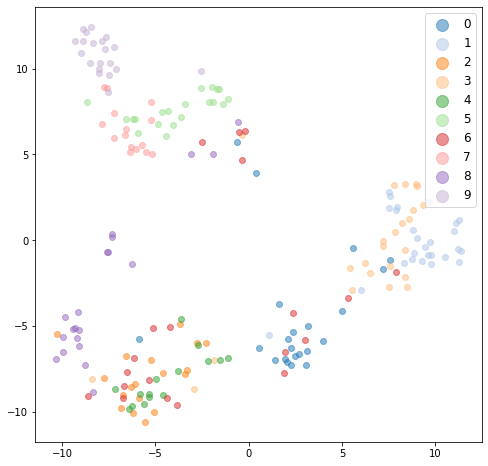

In [23]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# To Get only the correct data prediction  

In [24]:
def get_correct_embeddings(temb_test_embeddings_copy,dataset_full2_copy,test_targets_copy,test_predictions_copy):
    c=0
    print(len(temb_test_embeddings_copy))
    for i in range(len(temb_test_embeddings_copy)):
        try:
            if test_targets_copy[i]!=test_predictions_copy[i]:
                print(i)
                temb_test_embeddings_copy=np.delete(temb_test_embeddings_copy,i-c,axis=0)
                dataset_full2_copy=np.delete(dataset_full2_copy,i-c,axis=0)
                test_targets_copy=np.delete(test_targets_copy,i-c,axis=0)
                test_predictions_copy=np.delete(test_predictions_copy,i-c,axis=0)
                c=c+1
        except:
            print("")
    print(len(temb_test_embeddings_copy))
    return temb_test_embeddings_copy,dataset_full2_copy,test_targets_copy,test_predictions_copy
print(len(temb_test_embeddings_copy))

200


In [25]:
test_embeddings=temb_test_embeddings_copy
dataset_full2=dataset_full2_copy
test_targets=test_targets_copy
dataset_train_original2=dataset_full2

In [26]:
all_lists,all_data_points=all_list(test_embeddings,test_targets,dataset_full2)

(20, 400) 20 10


<ipython-input-17-3f24519255a4>:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-17-3f24519255a4>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-17-3f24519255a4>:52: FutureWarning: The input object of type 'Tensor' is an array-like implementing o

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [28]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(test_embeddings) 
kmeans.labels_

array([5, 2, 2, 8, 4, 3, 4, 2, 4, 6, 9, 7, 3, 8, 6, 4, 8, 9, 6, 8, 8, 5,
       4, 5, 8, 2, 2, 3, 4, 3, 4, 5, 2, 0, 0, 6, 8, 6, 2, 5, 2, 9, 6, 7,
       4, 8, 9, 4, 0, 4, 4, 7, 4, 5, 6, 3, 1, 6, 5, 0, 9, 3, 5, 2, 4, 4,
       8, 7, 5, 3, 1, 4, 5, 8, 2, 9, 6, 1, 6, 1, 6, 6, 5, 7, 8, 2, 9, 5,
       3, 7, 0, 6, 4, 8, 3, 0, 2, 4, 6, 7, 2, 4, 2, 0, 5, 7, 2, 3, 7, 3,
       1, 8, 0, 3, 7, 8, 4, 4, 4, 8, 5, 4, 2, 9, 6, 2, 8, 6, 3, 3, 6, 8,
       7, 2, 3, 5, 3, 5, 0, 4, 5, 1, 8, 0, 6, 8, 5, 8, 4, 1, 9, 3, 8, 9,
       8, 1, 8, 8, 6, 4, 8, 8, 0, 6, 2, 1, 8, 2, 2, 4, 2, 5, 5, 4, 5, 4,
       9, 4, 5, 5, 0, 8, 3, 4, 4, 3, 4, 3, 4, 4, 4, 5, 0, 6, 1, 8, 9, 9,
       5, 4])

In [29]:
len(kmeans.cluster_centers_)

10

In [30]:
all_clusters=kmeans.cluster_centers_

In [31]:
import math
import scipy.spatial as sp
import numpy as np
def get_dist(a,b):
    reslt=sp.distance.cosine(a,b)
    return reslt

In [32]:
len(test_embeddings)

200

# assign center point for each class 

In [33]:
center_classes=[]
for clas in all_lists:
    for cluster in all_clusters:
        p=cluster
        n = len(clas)
        dist = math.inf #(infinity)
        temb_test_embeddings=clas#.copy()
        for i in range(n):
            d = get_dist(p,temb_test_embeddings[i])
            if d<dist and d!=0: # to avoid the same point
                dist =d
                np1= temb_test_embeddings[i]
    center_classes.append(np1)
    indx=np.where(all_clusters==cluster)
    all_clusters=np.delete(all_clusters,indx[0][0],axis=0)
    print(len(all_clusters))
len(center_classes)

9
8
7
6
5
4
3
2
1
0


10

# get 10 neighbours for each class to perform (200 initial points)

In [34]:
points_class0=[]
points_class1=[]
points_class2=[]
points_class3=[]
points_class4=[]
points_class5=[]
points_class6=[]
points_class7=[]
points_class8=[]
points_class9=[]
all_points=[]
all_points.append(points_class0)
all_points.append(points_class1)
all_points.append(points_class2)
all_points.append(points_class3)
all_points.append(points_class4)
all_points.append(points_class5)
all_points.append(points_class6)
all_points.append(points_class7)
all_points.append(points_class8)
all_points.append(points_class9)


points_dist0=[]
points_dist1=[]
points_dist2=[]
points_dist3=[]
points_dist4=[]
points_dist5=[]
points_dist6=[]
points_dist7=[]
points_dist8=[]
points_dist9=[]
all_dist=[]
all_dist.append(points_dist0)
all_dist.append(points_dist1)
all_dist.append(points_dist2)
all_dist.append(points_dist3)
all_dist.append(points_dist4)
all_dist.append(points_dist5)
all_dist.append(points_dist6)
all_dist.append(points_dist7)
all_dist.append(points_dist8)
all_dist.append(points_dist9)

In [35]:
all_np=[]
for lab in range(10):
    p=center_classes[lab]
    n = len(all_lists[lab])
    dist = math.inf #(infinity)
    temb_test_embeddings=all_lists[lab]#kmeans.labels_
    for c in range(10): 
        n = len(temb_test_embeddings)
        dist = math.inf
        for i in range(n):
            d = get_dist(p,temb_test_embeddings[i])
            if d<dist and d!=0: # to avoid the same point
                dist =d
                np1= temb_test_embeddings[i]
        all_np.append(np1)
        indx=np.where(temb_test_embeddings==np1)
        print(len(temb_test_embeddings))
        
        temb_test_embeddings=np.delete(temb_test_embeddings,indx[0][0],axis=0)
        dataset_train_original2=np.delete(dataset_train_original2,indx[0][0],axis=0)
        
        
    n = len(temb_test_embeddings)
    dist = math.inf
    for i in range(n):
        d = get_dist(p,temb_test_embeddings[i])
        all_points[lab].append(all_data_points[lab][i])
        all_dist[lab].append(d)
len(all_np)

22
21
20
19
18
17
16
15
14
13
26
25
24
23
22
21
20
19
18
17
18
17
16
15
14
13
12
11
10
9
24
23
22
21
20
19
18
17
16
15
15
14
13
12
11
10
9
8
7
6
20
19


C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


18
17
16
15
14
13
12
11
20
19
18
17
16
15
14
13
12
11
15
14
13
12
11
10
9
8
7
6
20
19
18
17
16
15
14
13
12
11
20
19
18
17
16
15
14
13
12
11


100

# get the original images (as core_data) corrosponding to the 100 center points

In [36]:
indx=np.where(test_embeddings==all_np[0])
core_data1=dataset_full2[indx[0][0]]
core_data1,t=random_split([core_data1],[1,0])
core_data1=tuple(core_data1)
for point in all_np[1:]: 
    indx=np.where(test_embeddings==point)
    arr=dataset_full2[indx[0][0]]
    arr,t=random_split([arr],[1,0])
    arr=tuple(arr)
    core_data1=torch.utils.data.ConcatDataset([arr,core_data1])

In [37]:
core_data=core_data1
len(core_data)

100

# Embeddings of 100 core-set

In [38]:
test_embeddings2,test_targets2,test_predictions2,final_test_acc2=prepare_test_embeddings(core_data)

In [39]:
test_embeddings2,core_data,test_targets2,test_predictions2=get_correct_embeddings(test_embeddings2,core_data,test_targets2,test_predictions2)

100
1
2
7
8
9
13
17
18
20
23
32
33
35
37
38
45
48
53
64
69
71
77






















78


# visualize the ditribution of 100 core_data 

In [40]:
tsne = TSNE(2, verbose=1)
tsne_proj_core = tsne.fit_transform(test_embeddings2)
#tsne_proj = tsne.fit_transform(core_data.datasets[1])

[t-SNE] Computing 77 nearest neighbors...
[t-SNE] Indexed 78 samples in 0.001s...
[t-SNE] Computed neighbors for 78 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 78 / 78
[t-SNE] Mean sigma: 6.026938
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.962883
[t-SNE] KL divergence after 1000 iterations: 0.188532


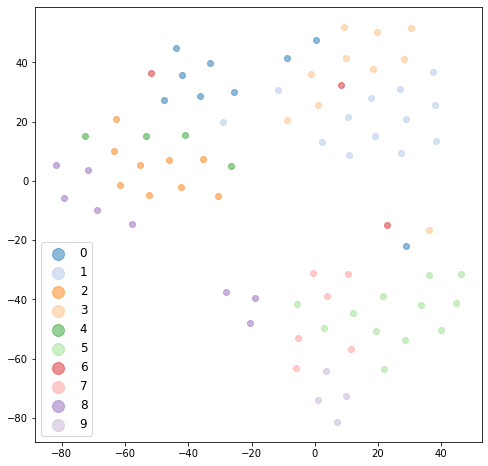

In [41]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets2==lab
    ax.scatter(tsne_proj_core[indices,0],tsne_proj_core[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

### **For one class SVM**

In [42]:
all_lists,_=all_list(test_embeddings2,test_targets2,core_data)

(4, 400) 8 10


In [43]:
X_train=np.concatenate((all_lists[9],all_lists[8],all_lists[7],all_lists[6],all_lists[5],all_lists[4],all_lists[3],all_lists[2],all_lists[1],all_lists[0]),axis=0)
len(X_train)

78

In [44]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.05, kernel = 'rbf', gamma = 'scale').fit(X_train)

In [45]:
def do_predict(dataset_train):
    test_loader = DataLoader(dataset=dataset_train, 
                                     batch_size=BATCH_SIZE, 
                                     drop_last=False,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)
    test_dataloader = test_loader

    all_true_labels = []
    all_predicted_labels = []
    test_embeddings = torch.zeros((0, 400), dtype=torch.float32)
    for batch in test_dataloader:
        features, labels = batch

        with torch.no_grad():  # since we don't need to backprop
            embeddings, logits = lightning_model(features)
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        predicted_labels = torch.argmax(logits, dim=1)
        all_predicted_labels.append(predicted_labels)
        all_true_labels.append(labels)

    test_embeddings = np.array(test_embeddings)
    all_predicted_labels = torch.cat(all_predicted_labels)
    all_true_labels = torch.cat(all_true_labels)
    all_predicted_labels=np.array(all_predicted_labels)
    all_true_labels=np.array(all_true_labels)

    test_acc = np.sum(all_predicted_labels == all_true_labels)
    final_test_acc = test_acc/len(test_embeddings)
    #print(final_test_acc)
    #all_predicted_labels[:5]
    
    return final_test_acc,test_targets,test_embeddings

In [46]:
dataset_full2 = tuple([tuple(e) for e in dataset_full2])
len(dataset_full2)

200

# Just to visualize outlier prediction (Take one example)

In [47]:
dd1,remaning = random_split(dataset_full2, [100,len(dataset_full2)-100])
# do prediction 
_,t_targets3,t_embeddings3=do_predict(dd1)

In [48]:
len(dd1)

100

In [49]:
prediction = one_class_svm.predict(t_embeddings3)
prediction = [1 if i==-1 else 0 for i in prediction]

In [50]:
all_prediction=prediction

# visualization of OneSvm 

In [51]:
core_data=tuple([tuple(e) for e in core_data])

In [52]:
#temb_training=torch.utils.data.ConcatDataset([core_data,temb_training])#core_data
test_embeddings4,test_targets4,_,_=prepare_test_embeddings(core_data)
print(len(test_embeddings4))

78


In [53]:
#do predict on one SVM
prediction2 = one_class_svm.predict(test_embeddings4)
# Change the anomalies' values to make it consistent with the true values
prediction2 = [1 if i==-1 else 0 for i in prediction2]
#print("The result of outlier is ",prediction)

In [54]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings4)

[t-SNE] Computing 77 nearest neighbors...
[t-SNE] Indexed 78 samples in 0.001s...
[t-SNE] Computed neighbors for 78 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 78 / 78
[t-SNE] Mean sigma: 6.026938
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.751911
[t-SNE] KL divergence after 1000 iterations: 0.197198


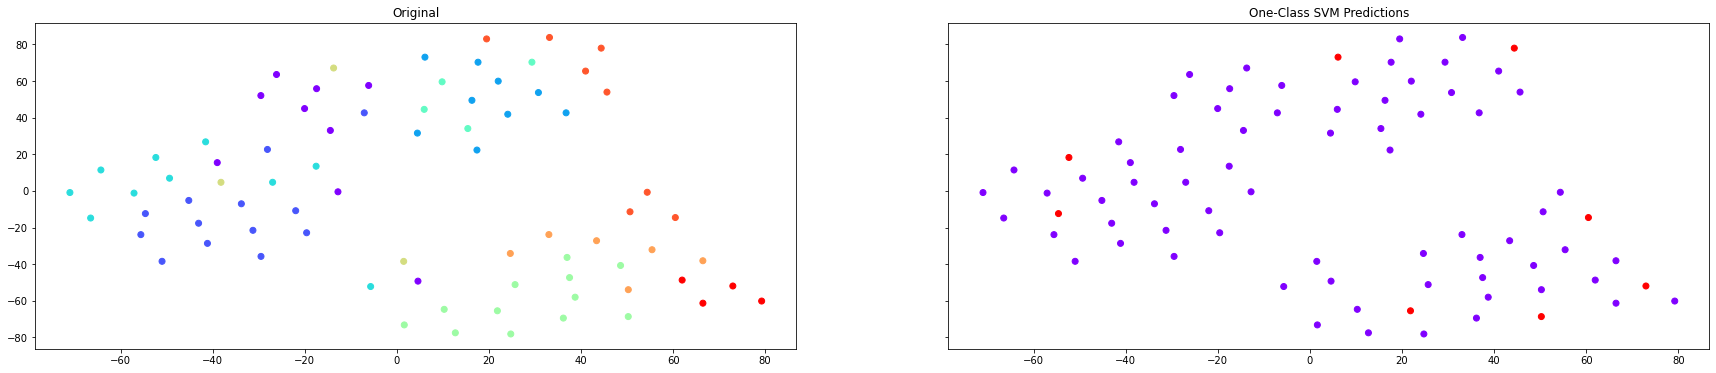

In [55]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(tsne_proj, columns=['feature1', 'feature2'])
df_test['y_test'] = test_targets4#test_targets4
df_test['one_class_svm_prediction'] = prediction2


df_core = pd.DataFrame(tsne_proj_core, columns=['feature1', 'feature2'])
df_core['y_test'] = test_targets2

fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(30,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], cmap='rainbow')


# start iterations 

In [56]:
data_test = FashionMNIST(".", train=False, download=True, transform=transform)

In [57]:
_,_,_,final_test_acc=prepare_test_embeddings(data_test)

In [58]:
final_test_acc

0.6395

In [59]:
dataset_full2_copy=remaining
dataset_train=dataset_train_original#core_data

In [60]:
import time
start_time = time.time()
CNN_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---


In [61]:
pred_list_val=[]
pred_list_train=[]
pred_list_test=[]
all_outliers=[]
len_outliers=[]
Times=[]

In [62]:
#pred_list_val.append(trainer.callback_metrics["val_acc"])
#pred_list_train.append(trainer.callback_metrics["train_acc"])
pred_list_test.append(final_test_acc)
Times.append(CNN_time)
len_outliers.append(200)

In [63]:
remaining=dataset_full2_copy

In [64]:
len(remaining)

49800

In [65]:
one_class_svm = OneClassSVM(nu=0.00005, kernel = 'poly', gamma ='auto').fit(test_embeddings)

# give an outlier score for all 49800 unlabeled training data and then take the highest 100 points in each round

In [66]:
kernel = 'poly'
gamma = 'auto'
NU=0.00001

roud=0
nu_out=300
while len(dataset_train)<7000:
#for c in range(2):
    start_time = time.time()
    #one_class_svm = OneClassSVM(nu=0.5, kernel = 'rbf', gamma = 'scale').fit(X_train)
    _,_,test_embeddings=do_predict(remaining)
    whole_prediction=one_class_svm.predict(test_embeddings)
    Scores=one_class_svm.score_samples(test_embeddings)
    len_out=0
    for out1 in whole_prediction:
        if out1==1:
            len_out=len_out+1
    print(len_out)
    df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
    df_remaining.sort_values(by=['Score'], inplace=True,ascending=True)
    Whole_outliers=torch.utils.data.ConcatDataset([[],[]])
    
    
    for i in range(nu_out):
        Whole_outliers=torch.utils.data.ConcatDataset([[(df_remaining['Remaining'][i][0],df_remaining['Remaining'][i][1])]
                                                   ,Whole_outliers])
        indx=np.where(test_embeddings==df_remaining['embeddings'][i])
        #print(indx)
        remaining=np.delete(remaining,indx[0][0],axis=0)
    remaining=tuple([tuple(e) for e in remaining])
    remaining=torch.utils.data.ConcatDataset([remaining,[]])
    
    dataset_train=torch.utils.data.ConcatDataset([Whole_outliers,dataset_train])
    print('All Remaining',len(remaining))
    #print('dataset_train_temp>>>>>>>>',len(dataset_train_temb))
    
    #train_dl = DataLoader(dataset_train, batch_size=64, shuffle=True)
    data_module = DataModule(dataset_train, dataset_val)
    
    
    #trainer.fit(model,train_dl)
    trainer.fit(model=lightning_model, datamodule=data_module)
    
    print('Gooooood their is valuable data')
    len_outliers.append(nu_out)


    #print(len(outlier),'......',i)
    #print(trainer.callback_metrics["val_acc"])
    #pred_list_val.append(trainer.callback_metrics["val_acc"])
    #pred_list_train.append(trainer.callback_metrics["train_acc"])

    
    _,_,_,final_test_acc=prepare_test_embeddings(data_test)
    pred_list_test.append(final_test_acc)
    # repeat one SVM
    #prepaire the new test_embeddings


    test_embeddings,test_targets,_,_=prepare_test_embeddings(dataset_train)
    print(len(test_embeddings),final_test_acc)
    
    one_class_svm = OneClassSVM(nu=NU, kernel = kernel, gamma =gamma).fit(test_embeddings)
    CNN_time = time.time() - start_time
    print("--- %s seconds ---" % (time.time() - start_time))
    Times.append(CNN_time)
    if roud>=0:
        nu_out=250
    roud=roud+1

492


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 49500



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

500


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 2it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
500 0.6386
--- 112.13160967826843 seconds ---
1503


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 49250



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

750


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 6it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
750 0.649
--- 195.66825151443481 seconds ---
2605


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 49000



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

1000


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 10it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
1000 0.661
--- 134.36346077919006 seconds ---
2565


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 48750



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

1250


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 14it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
1250 0.6745
--- 131.92840242385864 seconds ---
7536


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 48500



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

1500


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 18it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
1500 0.6692
--- 133.8804280757904 seconds ---
56


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 48250



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

1750


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 22it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
1750 0.6956
--- 130.03293991088867 seconds ---
75


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 48000



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

2000


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 26it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
2000 0.6932
--- 128.8745949268341 seconds ---
0


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 47750



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

2250


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 30it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
2250 0.712
--- 132.21532106399536 seconds ---
61


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 47500



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

2500


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 34it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
2500 0.7178
--- 129.04992079734802 seconds ---
72


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 47250



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

2750


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 38it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
2750 0.7159
--- 129.88110280036926 seconds ---
686


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 47000



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

3000


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 41it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
3000 0.7264
--- 132.82176661491394 seconds ---
1416


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 46750



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

3250


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 45it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
3250 0.7399
--- 132.52112483978271 seconds ---
22


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 46500



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

3500


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 49it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
3500 0.738
--- 132.94483852386475 seconds ---
2830


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 46250



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

3750


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 53it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
3750 0.7455
--- 128.54119873046875 seconds ---
10857


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 46000



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

4000


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 57it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
4000 0.7566
--- 133.03429508209229 seconds ---
384


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 45750



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

4250


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 61it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
4250 0.7448
--- 132.5943787097931 seconds ---
7309


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 45500



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

4500


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 65it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
4500 0.7675
--- 127.55575203895569 seconds ---
6923


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 45250



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

4750


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 69it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
4750 0.7696
--- 132.4348316192627 seconds ---
9174


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 45000



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

5000


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 73it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
5000 0.7732
--- 131.79458594322205 seconds ---
2


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 44750



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

5250


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 77it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
5250 0.7761
--- 132.0982871055603 seconds ---
7461


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 44500



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

5500


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 81it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
5500 0.7808
--- 131.64901542663574 seconds ---
455


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 44250



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

5750


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 84it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
5750 0.7871
--- 131.78245615959167 seconds ---
541


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 44000



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

6000


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 88it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
6000 0.79
--- 127.56046962738037 seconds ---
417


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 43750



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

6250


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 92it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
6250 0.7869
--- 131.3743302822113 seconds ---
6112


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 43500



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

6500


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 96it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
6500 0.7893
--- 132.08899235725403 seconds ---
294


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 43250



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

6750


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 100it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
6750 0.8024
--- 131.26862025260925 seconds ---
3658


<ipython-input-66-1e5fe62646cd>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3

All Remaining 43000



  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

7000


C:\Users\USER\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 104it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
7000 0.8005
--- 135.86320972442627 seconds ---


In [ ]:
all_data=[pred_list_test[:],len_outliers[:],Times[:]]
all_info=pd.DataFrame(all_data)
all_info=all_info.T
all_info.columns=['Test ACC','Length of outliers','Time']
all_info

In [68]:
all_info.to_csv('Result of (AL with LeNet) over Fashion.csv')